# **Hate Speech Detection on Twitter using RNNs**
***
### ***Computational Machine Learning II - Final project***

#### Alexandros Pappas, I Vivek Kaiwen, Yabra Muvdi



# **Overview**
Using two publicly available datasets, we attempt to use RNNs to predict the presence of hate speech in tweets. The tweets had been pre-screened and only tweets that contained hate speech-related words were included in the dataset. Amazon Turk was used to get labels on the dataset, which we codified as 1 for hate speech and 0 for non-hate speech.
In this notebook, we present our attempts in using several different embeddings and models.

## *Dealing with Class Imbalance*
In our dataset, hate speech represents only about 20 to 30% of the data. Therefore, we take some measures to ensure class balance in the training and validation sets. For each set, we take all the hate speech data and sample from the non-hate speech data such that the number of tweets in each category are equal. However, we do not balance the test set, since the model should be judged on its prediction performance on data that accurately reflects the population. 
## *Embeddings*
We tried two types of embeddings. First, we made our own embeddings by creating a dictionary of all the words in the training sample and mapping each word in the dictionary to a scalar. Only the first model presented here uses this embedding. 
Next, we used the FastText embedding. Produced by Facebook, this embedding is trained on Wikipedia articles and is available to the public online. In this embedding, each word in the dictionary is mapped to a vector of size 300, reflecting some meaning of the words. Using this pretrained embedding, we expected that the model would be able to pick up hate speech better and thus the predictions would improve. This was used for the rest of the models that we present here, and indeed outperforms the first embedding.

## *Models*
In addition to trying different types of embeddings, we experimented with various structures for our neural network. We started with a network where we learned the embeddings, then passed the data the embedded data through an RNN followed by and average pooling, a fully connected layer and final sigmoid layer in order to return probabilities for each class. Our second neural network, as mentioned before, used the pre-trained embeddings from FastText, thus our first layer consisted on an RNN followed by an activation function. We keept constante the rest of the structure. For our third neural network we decided to try a Max Pooling instead of average pooling. Lastly, we tried to experiment with the position of the pooling layer. The structure of all our neural networks is detailed in the table below. For the parameters of the RNN (hidden dimensions and dense layers) we performed some testing and will use 50 hidden dimensions and 3 dense layers since those seems to be the parameters with the best balance between the quality of results and the computational cost.


In [0]:
# get access to the content in Google Drive
from google.colab import drive
drive.mount('/content/drive')

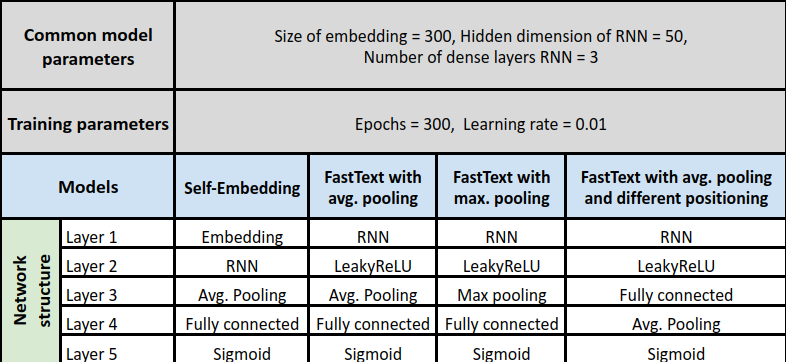

In [4]:
from google.colab import files
from IPython.display import Image

Image('/content/drive/My Drive/Pappas_Kaiwen_Muvdi_CML2/images/models_overview.png')

## *Regularization*
Here, we use an early stopping mechanism to prevent overfitting. We hold out a validation set and calculate the loss on this validation set in every training epoch. For every epoch where the validation loss does not decrease from the minimum validation loss achieved so far, the counter increases. If the validation loss achieves a new minimum, the model is saved and the counter is reset. If the patience level is reached by the counter, the early stopping mechanism is triggered and the training process stops. The selected model would be the saved model, which can be loaded and tested using the test set. 
## *Assessing Performance*
To assess model performance, we show the accuracy and AUC score on the test set for every model. Due to the class imbalance in the test set, we note that the accuracy score is insufficient to show that the model performs well, since it would achieve a reasonably high accuracy by simply classifying the vast majority of data points as non-hate speech. Therefore, the AUC is key to give a measure of the degree of separation of the two classes. 

The recall score will also be used to compare the models. A key use case of hate speech detection is to prevent the intensification of social tensions and the outbreak of social conflicts due to the actions of extreme individuals. Therefore, the failure to detect hate speech incurs a far greater cost than the misclassification of non-hate speech as hate speech. The recall score reflects the proportion of true positives to all actual positives; in other words, it shows the proportion of accurately labelled hate speech tweets to all hate speech tweets. A higher recall score therefore shows that our model is performing better for this use case. 

# **1. Set-up**

## **1.1 Libraries and permissions**

In [7]:
pip install pytorch-nlp

     |████████████████████████████████| 92kB 3.5MB/s 


In [0]:
from torchnlp.word_to_vector import FastText
import torch
from torch import nn
import pandas as pd
import pickle
import sklearn
import torch
import numpy as np
import string
import re
from sklearn.metrics import log_loss

In [0]:
# select the devide
device = torch.device('cuda')

## **1.2 Loading and merging data**

In [10]:
# data on hate speach from Davidson et al. (2017)
# https://github.com/t-davidson/hate-speech-and-offensive-language
filename = '/content/drive/My Drive/Pappas_Kaiwen_Muvdi_CML2/data/labeled_data.p'
df1 = pd.read_pickle(filename)
df1

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...
25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
25295,6,0,6,0,1,youu got wild bitches tellin you lies


In [11]:
# drop unnecessary columns from the other dataset
df1 = df1[['tweet', 'class']]

# we will modify the classes originally provided in order to turn the problem 
# into binary classification
df1.loc[df1['class'] == 2, 'class'] = 1 

# change the labels to 1 for hate speech and 0 for non-hate speech
df1['class'] = 1 - df1['class'] 

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [12]:
# data from the hateval2019 challenge
# https://www.aclweb.org/anthology/S19-2007/
df2 = pd.read_csv("/content/drive/My Drive/Pappas_Kaiwen_Muvdi_CML2/data/hateval2019_en_train.csv")

df3 = pd.read_csv("/content/drive/My Drive/Pappas_Kaiwen_Muvdi_CML2/data/hateval2019_en_test.csv")

# joining the two datasets provided by hateval 2019
df_hateval = pd.concat([df2,df3])

# drop unnecessary colunms
df_hateval = df_hateval.drop(labels = ['id', 'TR', 'AG'], axis = 1)

# rename columns 
df_hateval.rename(columns = {'text': 'tweet','HS':'class'}, inplace = True)

# Join the two datasets together
df = pd.concat([df1,df_hateval])

# lastly, reindex the dataframe
df = df.reset_index()[['tweet', 'class']]
df

,tweet,class
0,!!! RT @mayasolovely: As a woman you shouldn't...,0
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,0
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,0
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,0
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,0
...,...,...
36778,you can never take a L off a real bitch😩 im ho...,1
36779,@Brian_202 likes to call me a cunt & a bitch b...,1
36780,@kusha1a @Camio_the_wise @shoe0nhead 1. Never ...,1
36781,If i see and know you a hoe why would i hit yo...,1


# **2. Data preprocessing**

## **2.1 Cleanning tweets**

In [0]:
# some useful functions for preprocessing tweets
def replace(string, char):
  """ Function to replace multiple occurrences of a character 
      by a single appereance of the same character 
  """
  pattern = char + '{3,}'
  string = re.sub(pattern, char, string) 
  return string 

def replace_vocals(string):
  """ Function to replace multiple occurrences of vocals 
  """
  
  vocals = ["a","e", "i", "o", "u"]
  clean = string
  for char in vocals:
      clean = replace(clean,char)
  return clean

In [0]:
#Get tweets from df
tweets = list(df.tweet)

#Convert all tweets to lowercase
tweets_lc = [t.lower() for t in tweets]

#Delete all punctuation
tweets_lc = [t.translate(str.maketrans('', '', string.punctuation)) for t in tweets_lc]

#Delete all digits
tweets_lc = [re.sub('\d', '', t) for t in tweets_lc]

#Delete all line breaks that were converted to '\n'
tweets_lc = [re.sub('\n', ' ', t) for t in tweets_lc]

#Represent tweets as lists of words
tweets_words1 = [t.split() for t in tweets_lc]

# Remove any 'words' with 'http'
tweets_words = []
for t in tweets_words1:
  tweet = [replace_vocals(w) for w in t if 'http' not in w] 
  tweets_words.append(tweet)

## **2.2 Embeddings**

In [0]:
#Flatten the list to the get a list of all words
all_words = [word for tweet in tweets_words for word in tweet]

# Creating a dictionary that maps integers to the characters
int2word = dict(enumerate(all_words))

# Creating another dictionary that maps characters to integers
word2int2 = {word: ind for ind, word in int2word.items()}

# Change the values
word2int = dict()
unique_words = list(word2int2.keys())
for i in range(len(word2int2)):
    word2int[unique_words[i]] = i

In [0]:
#input list of lists of indices of words (and pad it so that every tweet is of the same length)
length_padded = np.max([len(i) for i in tweets_words])
blank = np.max(list(word2int.values()))+1

tweets_ind = []
for tweet in tweets_words:
  tw = []
  for w in tweet:
    tw.append(word2int[w])
  if len(tw)<length_padded:
    add = [blank]*(length_padded-len(tw))
    tw.extend(add)
  tweets_ind.append(tw)

input_seq = np.asarray(tweets_ind)
target_seq = np.asarray(df['class'].astype(np.int64))
dict_size = len(word2int)+1

## **2.3 Train/Validation/Test Split**

In [0]:
# train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(input_seq, target_seq, test_size=0.2, random_state=42)

In [0]:
# Remove some entries of class 0 in the trainning data in order to mitigate
# the class inbalance
import random
index_0 = [ i for i in range(len(y_train)) if y_train[i] == 0 ]
index_1 = [ i for i in range(len(y_train)) if y_train[i] == 1 ]
samp = random.sample(index_0, len(index_1))
samp.extend(index_1)
X_train = X_train[samp,:]
y_train = [y_train[index] for index in samp]

In [0]:
# now from the balanced train sample, we can generate a validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                    test_size=0.2, random_state=42)

In [0]:
# Transform to tensor and send to device
X_train = torch.Tensor(X_train).to(torch.int64)
X_test = torch.Tensor(X_test).to(torch.int64)
X_val = torch.Tensor(X_val).to(torch.int64)

y_train = torch.Tensor(y_train)
y_test = torch.Tensor(y_test)
y_val = torch.Tensor(y_val)

device = torch.device("cpu")
X_train = X_train.to(device)
X_test = X_test.to(device)
X_val = X_val.to(device)

y_train = y_train.to(device)
y_test = y_test.to(device)
y_val = y_val.to(device)

# **3. Models**

## **3.1 Early Stopping**

In [0]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        
        model_save_name = 'checkpoint.pt'
        path = F"/content/gdrive/My Drive/{model_save_name}" 

        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

## **3.2 Self Embedding Model**

In [0]:
class Model(nn.Module):
    def __init__(self, dict_size, embedding_size, output_size, hidden_dim, n_layers):
        super(Model, self).__init__()

        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.embedding_size = embedding_size
        self.dict_size = dict_size

        #Defining the layers
        
        # Embedding:
        # Our first layer will consist on finding appropriate embeddings for
        # all the words that appear in the tweets
        self.embedding = nn.Embedding(num_embeddings = self.dict_size, embedding_dim = self.embedding_size)
        
        # RNN Layer
        self.rnn = nn.RNN(self.embedding_size, self.hidden_dim, n_layers, batch_first=True)   
        
         # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_size)
             
        # Sigmoid
        # We need a final sigmoid function in order to get probabilities
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, last_state=None):
        
        batch_size = x.size(0) #x is bs,max_seq_len
        
        # 1. Embedding
        x = self.embedding(x)
  
        # 2. RNN layer 
        # Passing the input and hidden state into the model and obtaining outputs
        out, hidden = self.rnn(x, last_state)

        # 3. Fully connected layer
        out = self.fc(out)
        
        # 4. Average Pooling
        # After the fully connected layer we still have one output per each word in each tweet. 
        # Using Mean or Maxpooling we can collapse this into a single output per tweet
        # dim 0 is batch_size, dim1 is seq_length, dim2 is number of outputs of classifier
        out = torch.mean(out, dim = 1)
        
        # 5. Sigmoid
        out = self.sigmoid(out)
    
        return out, hidden

In [0]:
# Instantiate the model with hyperparameters
model = Model(dict_size=dict_size, embedding_size=300, output_size=1, hidden_dim=50, n_layers=3)

# We'll also set the model to the device that we defined earlier (default is CPU)
model = model.to(device)

# Define hyperparameters
n_epochs = 300

# Define Loss
criterion = nn.BCELoss()

# Optimizer
lr=0.01
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Initialize the EarlyStopping object
early_stopping = EarlyStopping(patience=50, verbose=True)

In [0]:
# Training Run
valid_loss = []

for epoch in range(1, n_epochs + 1):
    optimizer.zero_grad() # Clears existing gradients from previous epoch
    #input_seq = input_seq.to(device)
    output, hidden = model(X_train)
    output = output.to(device)
    
    loss = criterion(output.view(-1), y_train.view(-1))

    loss.backward() # Does backpropagation and calculates gradients
    optimizer.step() # Updates the weights accordingly

    valid_pred_tor, hidden2 = model(X_val) # Predicted probabilities on validation set
    valid_pred = [i[0] for i in valid_pred_tor.tolist()] # Convert predictions to list
    valid_loss.append(log_loss(y_val, valid_pred)) # Calculate the BCE loss on predicted probabilities

    # early_stopping checks if validation loss has decresed, 
    # and if it has, it will save the current model
    early_stopping(valid_loss[epoch-1], model)

    # Check if the early stopping should be triggered
    if early_stopping.early_stop:
        print("Early stop")
        break
    
    if epoch%10 == 0:
        print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
        print("Loss: {:.4f}".format(loss.item()))

Validation loss decreased (inf --> 0.820898).  Saving model ...
Validation loss decreased (0.820898 --> 0.694107).  Saving model ...
EarlyStopping counter: 1 out of 50
Validation loss decreased (0.694107 --> 0.692818).  Saving model ...
Validation loss decreased (0.692818 --> 0.691224).  Saving model ...
EarlyStopping counter: 1 out of 50
Validation loss decreased (0.691224 --> 0.688467).  Saving model ...
Validation loss decreased (0.688467 --> 0.686354).  Saving model ...
Validation loss decreased (0.686354 --> 0.686245).  Saving model ...
Validation loss decreased (0.686245 --> 0.683955).  Saving model ...
Epoch: 10/300............. Loss: 0.6853
Validation loss decreased (0.683955 --> 0.679994).  Saving model ...
Validation loss decreased (0.679994 --> 0.677636).  Saving model ...
Validation loss decreased (0.677636 --> 0.676078).  Saving model ...
Validation loss decreased (0.676078 --> 0.670555).  Saving model ...
Validation loss decreased (0.670555 --> 0.664619).  Saving model ..

In [0]:
import copy
model_self_emb = copy.deepcopy(model)
model_save_name = 'checkpoint.pt'
path = F"/content/{model_save_name}" 
model_self_emb.load_state_dict(torch.load(path))

<All keys matched successfully>

In [0]:
# Overview of the model
model_self_emb.eval()

Model(
  (embedding): Embedding(52116, 300)
  (rnn): RNN(300, 50, num_layers=3, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [0]:
# Get predictions for test data
y_pred, hidden = model_self_emb(X_test)

In [0]:
# transform Tensor back into a list for easier accuracy calculations
y_pred = y_pred.tolist()
y_pred = [y[0] for y in y_pred]

# same operation for the test data
y_test = y_test.tolist()

In [0]:
# Transform probabilities into classes
threshold = 0.5
y_pred_class = []
for y in y_pred:
    if y >= threshold:
        y_pred_class.append(1)
    else:
        y_pred_class.append(0)

In [0]:
# Performance metrics
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, roc_auc_score, precision_score, recall_score

print("************* Confusion Matrix ***************")
print(confusion_matrix(y_test, y_pred_class))
print("****************** Accuracy ******************")
print(accuracy_score(y_test, y_pred_class))
print("****************** ROC_AUC ******************")
print(roc_auc_score(y_test, y_pred_class))
print("****************** Recall ******************")
print(recall_score(y_test, y_pred_class))
print("****************** Precision ******************")
print(precision_score(y_test, y_pred_class))

# Save predictions and indicators for later evaluation
y_pred_prob_self_emb = y_pred
y_pred_self_emb = y_pred_class
confusion_self_emb = confusion_matrix(y_test, y_pred_class)
acc_self_emb = accuracy_score(y_test, y_pred_class)
auc_self_emb = roc_auc_score(y_test, y_pred_class)
recall_self_emb = recall_score(y_test, y_pred_class)
precision_self_emb = precision_score(y_test, y_pred_class)

************* Confusion Matrix ***************
[[4329 1763]
 [ 417  848]]
****************** Accuracy ******************
0.7036835666711975
****************** ROC_AUC ******************
0.6904799010689845
****************** Recall ******************
0.6703557312252965
****************** Precision ******************
0.3247797778628878


## **3.3 FastText Embeddings**

In [0]:
# get English word embeddings provided by FastText
vectors = FastText(language = "en")

In [0]:
# get FastText embeddings for each word in each tweet
tweets_emb = [[] for i in range(len(tweets_words))]

for i,tweet in enumerate(tweets_words):
  for word in tweet:
    try:
      tweets_emb[i].append(vectors[word].tolist())
    except:
      print('.')

In [0]:
# input list of lists of indices of words 
# (and pad it so that every tweet is of the same length)
length_padded = np.max([len(i) for i in tweets_emb])

tweets_ind = []
pad = [0 for i in range(300)] #torch.Tensor(np.array([0 for i in range(300)]))
for tweet in tweets_emb:
  if len(tweet)<length_padded:
    add = [pad]*(length_padded-len(tweet)) #[pad]*(length_padded-len(tweet))
    tweet.extend(add)
  tweets_ind.append(tweet)

In [0]:
# train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(np.asarray(tweets_ind).astype(np.float32), 
                                                    np.asarray(df['class'].astype(np.int64)), 
                                                    test_size=0.2, random_state=42)

In [0]:
# Remove some entries of class 1 in the trainning data in order to mitigate
# the class inbalance
import random
index_0 = [ i for i in range(len(y_train)) if y_train[i] == 0 ]
index_1 = [ i for i in range(len(y_train)) if y_train[i] == 1 ]
samp = random.sample(index_0, len(index_1))
samp.extend(index_1)
X_train = X_train[samp,:]
y_train = [y_train[index] for index in samp]

In [0]:
# now from the balanced train sample, we can generate a validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                    test_size=0.2, random_state=42)

In [0]:
# Transform to tensor and send to device
X_train = torch.Tensor(X_train)
X_test = torch.Tensor(X_test)
X_val = torch.Tensor(X_val)

y_train = torch.Tensor(y_train)
y_test = torch.Tensor(y_test)
y_val = torch.Tensor(y_val)

device = torch.device("cpu")
X_train = X_train.to(device)
X_test = X_test.to(device)
X_val = X_val.to(device)

y_train = y_train.to(device)
y_test = y_test.to(device)
y_val = y_val.to(device)

### **3.3.1 Avg. Pooling Model**

In [0]:
class Model(nn.Module):
    def __init__(self, embedding_size, output_size, hidden_dim, n_layers):
        super(Model, self).__init__()

        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.embedding_size = embedding_size

        #Defining the layers
        
        # RNN Layer
        self.rnn = nn.RNN(self.embedding_size, self.hidden_dim, n_layers, batch_first=True)   
        
        # Activation function (LeakyReLU)
        self.activation = nn.LeakyReLU()
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_size)
             
        # Sigmoid
        # We need a final sigmoid function in order to get probabilities
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, last_state=None):
        
        batch_size = x.size(0) #x is bs,max_seq_len
        
        # 1. RNN layer
        # Passing in the input and hidden state into the model and obtaining outputs
        out, hidden = self.rnn(x, last_state)
        
        # 2. Activation function
        out = self.activation(out)
        
        # 3. Fully connected layer
        out = self.fc(out)
        
        # 4. Average poooling
        # After the fully connected layer we still have one output per each word in each tweet. 
        # Using Mean or Maxpooling we can collapse this into a single output per tweet
        # dim 0 is batch_size, dim1 is seq_length, dim2 is number of outputs of classifier
        out = torch.mean(out, dim = 1)
  
        # 5. Sigmoid
        out = self.sigmoid(out)
    
        return out, hidden

In [0]:
# Instantiate the model with hyperparameters
model = Model(embedding_size=300, output_size=1, hidden_dim=50, n_layers=3)

# We'll also set the model to the device that we defined earlier (default is CPU)
model = model.to(device)

# Define hyperparameters
n_epochs = 300

# Define Loss
criterion = nn.BCELoss()

# Optimizer
lr=0.01
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Initialize the EarlyStopping object
early_stopping = EarlyStopping(patience=50, verbose=True)

In [0]:
# Training Run

valid_loss = []

for epoch in range(1, n_epochs + 1):
    optimizer.zero_grad() # Clears existing gradients from previous epoch
    #input_seq = input_seq.to(device)
    output, hidden = model(X_train)
    output = output.to(device)
    
    loss = criterion(output.view(-1), y_train.view(-1))

    loss.backward() # Does backpropagation and calculates gradients
    optimizer.step() # Updates the weights accordingly

    valid_pred_tor, hidden2 = model(X_val) # Predicted probabilities on validation set
    valid_pred = [i[0] for i in valid_pred_tor.tolist()] # Convert predictions to list
    valid_loss.append(log_loss(y_val, valid_pred)) # Calculate the BCE loss on predicted probabilities

    # early_stopping checks if validation loss has decresed, 
    # and if it has, it will save the current model
    early_stopping(valid_loss[epoch-1], model)

    # Check if the early stopping should be triggered
    if early_stopping.early_stop:
        print("Early stop")
        break

    #print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
    #print("Loss: {:.4f}".format(loss.item()))
    
    if epoch%10 == 0:
      print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
      print("Loss: {:.4f}".format(loss.item()))

Validation loss decreased (inf --> 0.694451).  Saving model ...
EarlyStopping counter: 1 out of 50
EarlyStopping counter: 2 out of 50
Validation loss decreased (0.694451 --> 0.688064).  Saving model ...
EarlyStopping counter: 1 out of 50
EarlyStopping counter: 2 out of 50
EarlyStopping counter: 3 out of 50
EarlyStopping counter: 4 out of 50
EarlyStopping counter: 5 out of 50
EarlyStopping counter: 6 out of 50
Epoch: 10/300............. Loss: 0.6903
EarlyStopping counter: 7 out of 50
Validation loss decreased (0.688064 --> 0.687431).  Saving model ...
Validation loss decreased (0.687431 --> 0.686572).  Saving model ...
Validation loss decreased (0.686572 --> 0.685350).  Saving model ...
Validation loss decreased (0.685350 --> 0.683738).  Saving model ...
Validation loss decreased (0.683738 --> 0.682707).  Saving model ...
Validation loss decreased (0.682707 --> 0.681624).  Saving model ...
Validation loss decreased (0.681624 --> 0.680999).  Saving model ...
Validation loss decreased (0.

In [0]:
model_avg_pool = copy.deepcopy(model)
model_save_name = 'checkpoint.pt'
path = F"/content/{model_save_name}" 
model_avg_pool.load_state_dict(torch.load(path))

<All keys matched successfully>

In [0]:
# Overview of the model
model_avg_pool.eval()

Model(
  (rnn): RNN(300, 50, num_layers=3, batch_first=True)
  (activation): LeakyReLU(negative_slope=0.01)
  (fc): Linear(in_features=50, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [0]:
# Get predictions for test data
y_pred, hidden = model_avg_pool(X_test)

In [0]:
# transform Tensor back into a list for easier accuracy calculations
y_pred = y_pred.tolist()
y_pred = [y[0] for y in y_pred]

In [0]:
# Tranform probabilities into classes
threshold = 0.5
y_pred_class = []
for y in y_pred:
    if y >= threshold:
        y_pred_class.append(1)
    else:
        y_pred_class.append(0)

In [0]:
# Performance metrics
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, roc_auc_score
print("************* Confusion Matrix ***************")
print(confusion_matrix(y_test, y_pred_class))
print("****************** Accuracy ******************")
print(accuracy_score(y_test, y_pred_class))
print("****************** ROC_AUC *******************")
print(roc_auc_score(y_test, y_pred_class))
print("****************** Recall ******************")
print(recall_score(y_test, y_pred_class))
print("****************** Precision ******************")
print(precision_score(y_test, y_pred_class))

# Save predictions and indicators for later evaluation
y_pred_prob_avg_pool = y_pred
y_pred_avg_pool = y_pred_class
confusion_avg_pool = confusion_matrix(y_test, y_pred_class)
acc_avg_pool = accuracy_score(y_test, y_pred_class)
auc_avg_pool = roc_auc_score(y_test, y_pred_class)
recall_avg_pool = recall_score(y_test, y_pred_class)
precision_avg_pool = precision_score(y_test, y_pred_class)

************* Confusion Matrix ***************
[[4425 1667]
 [ 357  908]]
****************** Accuracy ******************
0.724887861900231
****************** ROC_AUC *******************
0.7220745019062127
****************** Recall ******************
0.7177865612648221
****************** Precision ******************
0.35262135922330096


### **3.3.2 Max Pooling Model**

In [0]:
class Model(nn.Module):
    def __init__(self, embedding_size, output_size, hidden_dim, n_layers):
        super(Model, self).__init__()

        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.embedding_size = embedding_size

        #Defining the layers
        
        # RNN Layer
        self.rnn = nn.RNN(self.embedding_size, self.hidden_dim, n_layers, batch_first=True)   
        
        # Activation function (LeakyReLU)
        self.activation = nn.LeakyReLU()
        
        # Max Pooling layer
        self.pooling = nn.AdaptiveMaxPool2d((1,1))
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_size)
             
        # Sigmoid
        # We need a final sigmoid function in order to get probabilities
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, last_state=None):
        
        batch_size = x.size(0) #x is bs,max_seq_len
        
        # 1. RNN layer
        # Passing in the input and hidden state into the model and obtaining outputs
        out, hidden = self.rnn(x, last_state)
        
        # 2. Activation function
        out = self.activation(out)
        
        # 3. Fully connected layer
        out = self.fc(out)
        
        # 4. Max pooling
        # After the fully connected layer we still have one output per each word in each tweet. 
        # Using Mean or Maxpooling we can collapse this into a single output per tweet
        # dim 0 is batch_size, dim1 is seq_length, dim2 is number of outputs of classifier
        out = self.pooling(out)

        # 5. Sigmoid
        out = self.sigmoid(out)
    
        return out, hidden

In [0]:
# Instantiate the model with hyperparameters
model = Model(embedding_size=300, output_size=1, hidden_dim=50, n_layers=3)
# We'll also set the model to the device that we defined earlier (default is CPU)
model = model.to(device)

# Define hyperparameters
n_epochs = 300

# Define Loss
criterion = nn.BCELoss()

# Optimizer
lr=0.01
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Initialize the EarlyStopping object
early_stopping = EarlyStopping(patience=50, verbose=True)

In [0]:
# Training Run

valid_loss = []

for epoch in range(1, n_epochs + 1):
    optimizer.zero_grad() # Clears existing gradients from previous epoch
    output, hidden = model(X_train)
    output = output.to(device)
    
    loss = criterion(output.view(-1), y_train.view(-1))

    loss.backward() # Does backpropagation and calculates gradients
    optimizer.step() # Updates the weights accordingly

    valid_pred_tor, hidden2 = model(X_val) # Predicted probabilities on validation set
    valid_pred = [i[0] for i in valid_pred_tor.tolist()] # Convert predictions to list
    valid_loss.append(log_loss(y_val, valid_pred)) # Calculate the BCE loss on predicted probabilities

    # early_stopping checks if validation loss has decresed, 
    # and if it has, it will save the current model
    early_stopping(valid_loss[epoch-1], model)

    # Check if the early stopping should be triggered
    if early_stopping.early_stop:
        print("Early stop")
        break
    
    if epoch%10 == 0:
      print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
      print("Loss: {:.4f}".format(loss.item()))

Validation loss decreased (inf --> 0.691801).  Saving model ...
Validation loss decreased (0.691801 --> 0.687635).  Saving model ...
Validation loss decreased (0.687635 --> 0.682981).  Saving model ...
Validation loss decreased (0.682981 --> 0.676567).  Saving model ...
Validation loss decreased (0.676567 --> 0.655131).  Saving model ...
Validation loss decreased (0.655131 --> 0.638101).  Saving model ...
Validation loss decreased (0.638101 --> 0.629746).  Saving model ...
Validation loss decreased (0.629746 --> 0.614482).  Saving model ...
Validation loss decreased (0.614482 --> 0.597287).  Saving model ...
EarlyStopping counter: 1 out of 50
Epoch: 10/300............. Loss: 0.5890
EarlyStopping counter: 2 out of 50
EarlyStopping counter: 3 out of 50
Validation loss decreased (0.597287 --> 0.588928).  Saving model ...
EarlyStopping counter: 1 out of 50
Validation loss decreased (0.588928 --> 0.581542).  Saving model ...
EarlyStopping counter: 1 out of 50
Validation loss decreased (0.58

In [0]:
model_max_pool = copy.deepcopy(model)
model_save_name = 'checkpoint.pt'
path = F"/content/{model_save_name}" 
model_max_pool.load_state_dict(torch.load(path))

<All keys matched successfully>

In [0]:
# Overview of the model
model_max_pool.eval()

Model(
  (rnn): RNN(300, 50, num_layers=3, batch_first=True)
  (activation): LeakyReLU(negative_slope=0.01)
  (pooling): AdaptiveMaxPool2d(output_size=(1, 1))
  (fc): Linear(in_features=50, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [0]:
# Get predictions for test data
y_pred, hidden = model_max_pool(X_test)

# transform Tensor back into a list for easier accuracy calculations
y_pred = y_pred.tolist()
y_pred = [y[0][0] for y in y_pred]

In [0]:
# Transform probabilities into classes
threshold = 0.5
y_pred_class = []
for y in y_pred:
    if y >= threshold:
        y_pred_class.append(1)
    else:
        y_pred_class.append(0)

In [0]:
# Performance metrics
print("************* Confusion Matrix ***************")
print(confusion_matrix(y_test, y_pred_class))
print("****************** Accuracy ******************")
print(accuracy_score(y_test, y_pred_class))
print("****************** ROC_AUC *******************")
print(roc_auc_score(y_test, y_pred_class))
print("****************** Recall ******************")
print(recall_score(y_test, y_pred_class))
print("****************** Precision ******************")
print(precision_score(y_test, y_pred_class))

# Save predictions and indicators for later evaluation
y_predprob_max_pool = y_pred
y_pred_max_pool = y_pred_class
confusion_max_pool = confusion_matrix(y_test, y_pred_class)
acc_max_pool = accuracy_score(y_test, y_pred_class)
auc_max_pool = roc_auc_score(y_test, y_pred_class)
recall_max_pool = recall_score(y_test, y_pred_class)
precision_max_pool = precision_score(y_test, y_pred_class)

************* Confusion Matrix ***************
[[4299 1793]
 [ 298  967]]
****************** Accuracy ******************
0.7157808889493
****************** ROC_AUC *******************
0.735053228623556
****************** Recall ******************
0.7644268774703558
****************** Precision ******************
0.3503623188405797


### **3.3.3 Avg. Pooling (different position) Model**

In [0]:
class Model(nn.Module):
    def __init__(self, embedding_size, output_size, hidden_dim, n_layers):
        super(Model, self).__init__()

        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.embedding_size = embedding_size

        #Defining the layers
        
        # RNN Layer
        self.rnn = nn.RNN(self.embedding_size, self.hidden_dim, n_layers, batch_first=True)   
        
        # Activation function
        self.activation = nn.LeakyReLU()
        
        # Avg. Pooling
        self.pooling = nn.AdaptiveAvgPool2d((1,self.hidden_dim))
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_size)
             
        # Sigmoid
        # We need a final sigmoid function in order to get probabilities
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, last_state=None):
        
        batch_size = x.size(0) #x is bs,max_seq_len
        
        # 1. RNN layer
        # Passing in the input and hidden state into the model and obtaining outputs
        out, hidden = self.rnn(x, last_state)
        
        # 2. Activation function
        out = self.activation(out)

        # 3. Average poolong
        # IMPORTANT: for this model we are doing the pooling before the
        # fully connected layer in order to experiment with a different
        # structure for our neural network
        out = self.pooling(out)
        
        # 4. Fully connected
        out = self.fc(out)
        
        # 5. Sigmoid
        # After the fully connected layer we still have one output per each word in each tweet. 
        # Using Mean or Maxpooling we can collapse this into a single output per tweet
        # dim 0 is batch_size, dim1 is seq_length, dim2 is number of outputs of classifier
        out = self.sigmoid(out)
    
        return out, hidden

In [0]:
# Instantiate the model with hyperparameters
model = Model(embedding_size=300, output_size=1, hidden_dim=50, n_layers=3)
# We'll also set the model to the device that we defined earlier (default is CPU)
model = model.to(device)

# Define hyperparameters
n_epochs = 300

# Define Loss
criterion = nn.BCELoss()

# Optimizer
lr=0.01
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Initialize the EarlyStopping object
early_stopping = EarlyStopping(patience=50, verbose=True)

In [0]:
# Training Run

valid_loss = []

for epoch in range(1, n_epochs + 1):
    optimizer.zero_grad() # Clears existing gradients from previous epoch
    output, hidden = model(X_train)
    output = output.to(device)
    
    loss = criterion(output.view(-1), y_train.view(-1))

    loss.backward() # Does backpropagation and calculates gradients
    optimizer.step() # Updates the weights accordingly

    valid_pred_tor, hidden2 = model(X_val) # Predicted probabilities on validation set
    valid_pred = [i[0] for i in valid_pred_tor.tolist()] # Convert predictions to list
    valid_loss.append(log_loss(y_val, valid_pred)) # Calculate the BCE loss on predicted probabilities

    # early_stopping checks if validation loss has decresed, 
    # and if it has, it will save the current model
    early_stopping(valid_loss[epoch-1], model)

    # Check if the early stopping should be triggered
    if early_stopping.early_stop:
        print("Early stop")
        break 
    
    if epoch%10 == 0:
      print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
      print("Loss: {:.4f}".format(loss.item()))

Validation loss decreased (inf --> 0.714121).  Saving model ...
Validation loss decreased (0.714121 --> 0.693671).  Saving model ...
Validation loss decreased (0.693671 --> 0.691710).  Saving model ...
Validation loss decreased (0.691710 --> 0.690069).  Saving model ...
Validation loss decreased (0.690069 --> 0.685794).  Saving model ...
Validation loss decreased (0.685794 --> 0.682268).  Saving model ...
Validation loss decreased (0.682268 --> 0.678516).  Saving model ...
Validation loss decreased (0.678516 --> 0.676216).  Saving model ...
Validation loss decreased (0.676216 --> 0.673845).  Saving model ...
Validation loss decreased (0.673845 --> 0.672153).  Saving model ...
Epoch: 10/300............. Loss: 0.6738
Validation loss decreased (0.672153 --> 0.670009).  Saving model ...
Validation loss decreased (0.670009 --> 0.666920).  Saving model ...
Validation loss decreased (0.666920 --> 0.664037).  Saving model ...
EarlyStopping counter: 1 out of 50
EarlyStopping counter: 2 out of 5

In [0]:
model_avg_pool_diff = copy.deepcopy(model)
model_save_name = 'checkpoint.pt'
path = F"/content/{model_save_name}" 
model_avg_pool_diff.load_state_dict(torch.load(path))

<All keys matched successfully>

In [0]:
# Overview of the model
model_avg_pool_diff.eval()

Model(
  (rnn): RNN(300, 50, num_layers=3, batch_first=True)
  (activation): LeakyReLU(negative_slope=0.01)
  (pooling): AdaptiveAvgPool2d(output_size=(1, 50))
  (fc): Linear(in_features=50, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [0]:
# Get predictions for test data
y_pred, hidden = model_avg_pool_diff(X_test)

# transform Tensor back into a list for easier accuracy calculations
y_pred = y_pred.tolist()
y_pred = [y[0][0] for y in y_pred]

In [0]:
# Transform probabilities into classes
threshold = 0.5
y_pred_class = []
for y in y_pred:
    if y >= threshold:
        y_pred_class.append(1)
    else:
        y_pred_class.append(0)

In [0]:
# Performance metrics
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, roc_auc_score
print("************* Confusion Matrix ***************")
print(confusion_matrix(y_test, y_pred_class))
print("****************** Accuracy ******************")
print(accuracy_score(y_test, y_pred_class))
print("****************** ROC_AUC *******************")
print(roc_auc_score(y_test, y_pred_class))
print("****************** Recall ******************")
print(recall_score(y_test, y_pred_class))
print("****************** Precision ******************")
print(precision_score(y_test, y_pred_class))

# Save predictions and indicators for later evaluation
y_predprob_avg_pool_diff = y_pred
y_pred_avg_pool_diff = y_pred_class
confusion_avg_pool_diff = confusion_matrix(y_test, y_pred_class)
acc_avg_pool_diff = accuracy_score(y_test, y_pred_class)
auc_avg_pool_diff = roc_auc_score(y_test, y_pred_class)
recall_avg_pool_diff = recall_score(y_test, y_pred_class)
precision_avg_pool_diff = precision_score(y_test, y_pred_class)

************* Confusion Matrix ***************
[[4002 2090]
 [ 290  975]]
****************** Accuracy ******************
0.6764985727878211
****************** ROC_AUC *******************
0.7138390528367404
****************** Recall ******************
0.7707509881422925
****************** Precision ******************
0.3181076672104405


# **4. Results**

Below we present a table and a bar graph that summarize and compare all the results obtained in the above section.

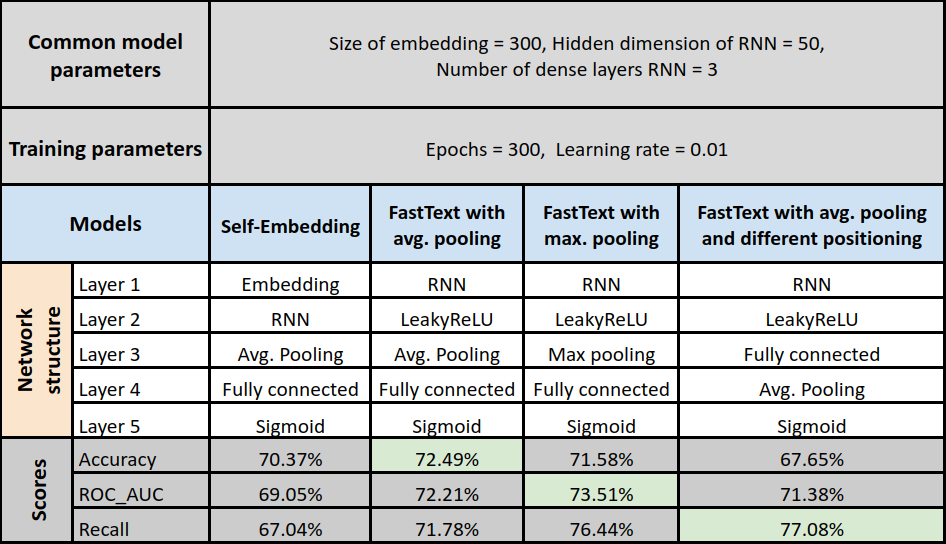

In [14]:
Image('/content/drive/My Drive/Pappas_Kaiwen_Muvdi_CML2/images/models_results.png')

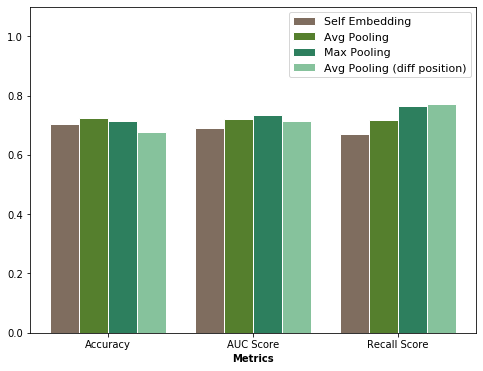

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

mods = ['Self Embedding','Avg Pooling','Max Pooling','Avg Pooling (diff position)']
metrics = ['Accuracy', 'AUC Score', 'Recall Score']

self_emb = [acc_self_emb, auc_self_emb, recall_self_emb]
avg_pool = [acc_avg_pool, auc_avg_pool, recall_avg_pool]
max_pool = [acc_max_pool, auc_max_pool, recall_max_pool]
avg_pool_diff = [acc_avg_pool_diff, auc_avg_pool_diff, recall_avg_pool_diff]

barWidth=0.2
r1 = np.arange(len(avg_pool))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]

plt.figure(figsize=(8,6))
metricticks = [(x + y)/2 for x, y in zip(r3, r4)]
plt.bar(r2, self_emb, color='#7f6d5f', width=barWidth, edgecolor='white', label=mods[0])
plt.bar(r3, avg_pool, color='#557f2d', width=barWidth, edgecolor='white', label=mods[1])
plt.bar(r4, max_pool, color='#2d7f5e', width=barWidth, edgecolor='white', label=mods[2])
plt.bar(r5, avg_pool_diff, color='#86c29c', width=barWidth, edgecolor='white', label=mods[3])
plt.xlabel('Metrics', fontweight='bold')
plt.xticks(ticks=metricticks, labels=metrics)
plt.ylim(0,1.1)
plt.legend(prop={'size': 11})
plt.show()

## Analysis

In general, the usage of the FastText embedding outperformed the usage of our own embeddings, which was to be expected, since the FastText embedding contained more information about the words. Among the models where the FastText embedding was used, the Average Pooling and Max Pooling models (with the original sequence) did the best. The Average Pooling model with a different sequence did worse, as it would overclassify points as 0's or 1's. (In this particular run, it overclassified points as 1's, thereby giving a high recall score; however, its poor performance overall can be seen in its low accuracy score.)

# **5. Embedded space exploration**

The last step of our project is to perform a PCA in order to visualize how good our resuts are depicted in a two dimension plot. As we can see from the graph, the words are clustered effectively with the 'good words' concetrated in the middle section of the graph. Furthermore, 'extreme bad words' such as *racists* are in the exact opposite direction from words like *love*. 

In [0]:
# Transform FastText embeddings into a Numpy array
emb = np.asarray(vectors.vectors)

from sklearn.decomposition import PCA
# Perform a PCA decomposition on the embeddings matrix
pca = PCA(n_components=2, whiten=True)  
pca.fit(emb)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=True)

In [0]:
import matplotlib.pyplot as plt
# Function to visualize the word embeddings in the first two principal components
def plot_similar_word(src_words, src_word2id, src_emb, tgt_words, tgt_word2id, tgt_emb, pca):
    Y = []
    word_labels = []
    for sw in src_words:
        Y.append(src_emb[src_word2id[sw]])
        word_labels.append(sw)
    for tw in tgt_words:
        Y.append(tgt_emb[tgt_word2id[tw]])
        word_labels.append(tw)
    # find tsne coords for 2 dimensions
    Y = pca.transform(Y)
    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    # display scatter plot
    plt.figure(figsize=(10, 8), dpi=80)
    plt.scatter(x_coords, y_coords, marker='x')
    for k, (label, x, y) in enumerate(zip(word_labels, x_coords, y_coords)):
        color = 'blue' if k < len(src_words) else 'red'  # src words in blue / tgt words in red
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points', fontsize=19,
                     color=color, weight='bold')
    plt.xlim(x_coords.min() - 0.2, x_coords.max() + 0.2)
    plt.ylim(y_coords.min() - 0.2, y_coords.max() + 0.2)
    plt.title('Visualization of the word embedding space')
    plt.show()

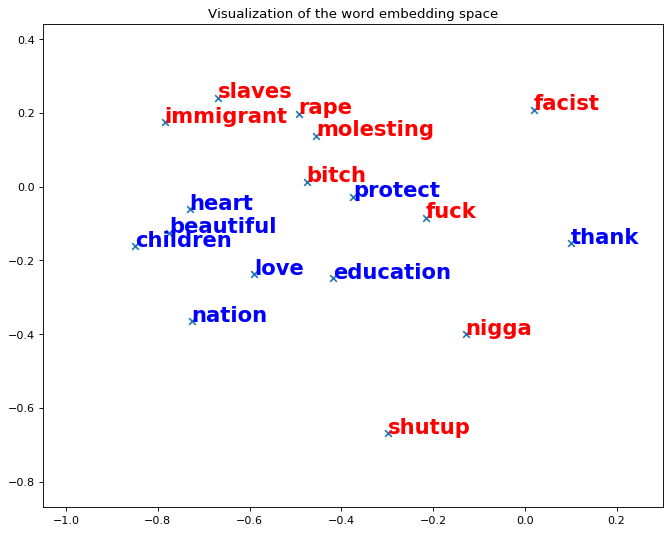

In [0]:
# get 5 random input words
good_words = ['heart', 'beautiful', 'love','education','protect','thank','children','nation']
bad_words = ['bitch', 'fuck', 'rape','molesting','slaves','facist', 'nigga', 'immigrant', 'shutup']
# assert words in dictionaries
for gw in good_words:
    assert gw in vectors.token_to_index, '"%s" not in source dictionary' % sw
for bw in bad_words:
    assert bw in vectors.token_to_index, '"%s" not in target dictionary' % sw

# plot results
plot_similar_word(good_words, vectors.token_to_index, emb ,bad_words, 
                  vectors.token_to_index, emb, pca)